# This notebook would compare performances from various models


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
from skimage.io import imread
import glob
import termcolor
from termcolor import colored
import pandas as pd
import seaborn as sns
import logging
logger = logging.getLogger()

%matplotlib inline
plt.style.use('bmh')
pd.set_option('max_columns', 500)
pd.set_option('max_colwidth', 750)
pd.set_option('max_rows',999)


In [2]:
# %%HTML
# <style type="text/css">
# table.dataframe td, table.dataframe th {
#     border: 1px  black solid !important;
#   color: black !important;
#   background-color: yellow;
# }
# </style>

In [3]:
# Highlight row
def highlight_row(r, n, fBeta, th):
    if ((r.F1_Beta >= fBeta)  & (r.Threshold <= th)):
        return ['background-color: yellow']*n
    else:
        return ['background-color: white']*n

## Declare Various models with description and global variables
## Model name Standardization: To get all parameters to display when comparing models
##### Eg. I200_S567_LR000002_D_E1600_BL_O6G4 
##### I :Number of images
##### S :Scale the source iamge, 567 means 1/3 image scale in 50%, 1/3 image in 50% and 1/3 image in 60% (multi scaling)
##### LR:Learning Rate
##### D :Denoise flag true, if no D then it means denoise flag default to false
##### E :Number of epochs
##### BL:Whether images are blended or in pure form, if not blended , BL will not be there in name
##### O6G4: If Blended then only we would have this parat, this means 60% from Original image and 40% from Generated image

In [4]:
#Thresholds in image comparison
# thresholds = [100, 150, 200, 210, 215, 220, 225, 230, 235, 240, 250]
thresholds = [100, 125, 130, 150, 200,]
beta = 2.0 #Higher beta value means more importance on recall

font_size=15
crop_size = (800, 800)
transparent_color = np.zeros(crop_size)

#Comparable model
models_to_compare_mem = [
    'Model_Base',
#     'I200_S567_LR000002_D',
#     'I200_S567_LR000002_D_E1600_R800',
    'I200_S567_LR000002_D_E1600_BL_O6G4',
    'I200_S567_LR000002_D_E1600_BL_O6G4_R800',
    'I200_S567_LR000002_D_E1600_BL_O1G9_R800',
#     'I200_S567_LR000002_D_E1600_BL_O3G7_R800',
    'I200_S567_LR000002_D_E1600_BL_O9G1_R800',
]


models_to_compare_mito = [
    'Model_Base',
#     'I200_S567_LR000002_D',
#     'I200_S567_LR000002_D_E1600',
    'I200_S567_LR000002_D_E1600_BL_O1G9',
    'I200_S567_LR000002_D_E1600_BL_O3G7',
    'I200_S567_LR000002_D_E1600_BL_O9G1',
#     'I200_S567_LR000002_D_E1600_BL_O1G9_R800',
    'I200_S567_LR000002_D_E1600_BL_O9G1_R800',
]

#Predic organelle 
# organelle = ["membranes", "mitos"]
organelle_mitos = ['mitos']
organelle_membranes = ['membranes']
mem_str = 'membranes'
mito_str = 'mitos'

#Display columns
cols = ['Model', 'Threshold',
        'Images', 'Scale', 'Epoch', 'Denoise', 'Learning Rate','Retrained', 'Blended', 'Original(%)', 'Generated(%)',
        'Precision','Recall','Specificity',
        'F1-Improvement (%) on Base','Accuracy','Accuracy-Improvement (%) on Base', 'F1', 'F_Beta']

hyperParam_col = ['Model', 'Threshold', 'Images', 'Scale', 'Epoch', 'Denoise', 'Learning Rate','Retrained',  'Blended', 'Original(%)', 'Generated(%)']

#Kept in main column list if need to get those data in display
drop_columns=['F1-Improvement (%) on Base','Accuracy-Improvement (%) on Base']


base_model = 'Base Model, prediction on original images'
base_model_key = 'Model_Base'

#Model Name Dictionary, just to provide verbose description
model_dict ={
    'Model_Base': base_model,
    'I200_S567_LR000002_D': ': Base Model, prediction on generated images by GAN, and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600': ': Base Model, prediction on generated images by GAN, hiher epoch and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_R800': ': Re-trained Model (+800 iterations) with generated & groundtruth data; prediction on generated images by GAN, and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O1G9_R800': ': Re-trained Model (+800 iterations) with generated & groundtruth data, prediction on blended(10% Original 90% Generated) images, and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O3G7_R800': ': Re-trained Model (+800 iterations) with generated & groundtruth data, prediction on blended(30% Original 70% Generated) images, and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O9G1_R800': ': Re-trained Model (+800 iterations) with generated & groundtruth data, prediction on blended(90% Original 10% Generated) images, and tuned hyperparameters',
    'I200_S567_LR000002_D_R800': ': Re-trained Model (+800 iterations) with generated & groundtruth data, prediction on generated images by GAN and tuned hyperparameters',
    'I200_S567_LR000002_D_R400': ': Re-trained Model (+400 iterations) with Generated Images & Groundtruth data, Input: Generated images by GAN and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O9G1': ': Base Model, prediction on blended(90% Original 10% Generated) images and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O8G2': ': Base Model, prediction on blended(80% Original 20% Generated) images and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O7G3': ': Base Model , prediction on blended(70% Original 30% Generated) images and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O6G4': ': Base Model , prediction on blended(60% Original 40% Generated) images and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O5G5': ': Base Model , prediction on blended(50% Original 50% Generated) and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O4G6': ': Base Model , prediction on blended(40% Original 60% Generated) images and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O3G7': ': Base Model , prediction on blended(30% Original 70% Generated) images and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O2G8': ': Base Model , prediction on blended(20% Original 80% Generated) images and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O1G9': ': Base Model , prediction on blended(10% Original 90% Generated) images and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O8G2_R800': ': Re-trained Model (+800 iterations) with generated & groundtruth data, prediction on blended(80% Original 20% Generated) images, and tuned hyperparameters',
    'I200_S567_LR000002_D_E1600_BL_O6G4_R800': ': Re-trained Model (+800 iterations) with generated & groundtruth data, prediction on blended(60% Original 40% Generated) images, and tuned hyperparameters',
}

In [5]:
# Method to avoid div by zero error in case of higher threshold Mito evalualution
def getDivByZeroSafe(val):
    if((round(val,4)) == 0):
        val = 0.0001
    return val


##  Find model prformance metrics  Precision, Recall, Accuracy, F1-Score, F-Beta score

In [6]:
  
# Create your dictionary class 
class score_dictionary(dict): 
  
    # __init__ function 
    def __init__(self): 
        self = dict() 
          
    # Function to add key:value 
    def add(self, key, value): 
        self[key] = value 

        
        
# Performance metrics              
def get_performance_metrics(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    total = TP + FP + FN + TN
    TP_FP = getDivByZeroSafe(TP + FP)
    TP_FN = getDivByZeroSafe(TP + FN)
    TN_FP = getDivByZeroSafe(TN + FP)
    
    TP_TN = (TP + TN)
    
    precision = (TP/TP_FP)
    recall = (TP/TP_FN)
    PR = getDivByZeroSafe(precision + recall)
    F1 = ((2 * precision * recall)/PR)
    beta_NR = (precision * recall)
    beta_DR = ((beta**2)*precision)+recall
    beta_DR = getDivByZeroSafe(beta_DR)
#     print('beta_DR:',beta_DR)
    F_Beta = (1 + beta**2)*(beta_NR/beta_DR)

    accuracy = (TP_TN/total)
    specificity = (TN/TN_FP)

    dict_score = score_dictionary() 

    dict_score.add("Precision", round(precision, 4)) 
    dict_score.add("Recall", round(recall, 4)) 
    dict_score.add("Specificity", round(specificity, 4)) 
    dict_score.add("F1", round(F1, 4))
    
    dict_score.add("F_Beta", round(F_Beta, 4)) 
    
    dict_score.add("Accuracy", round(accuracy, 4)) 
    return dict_score

## Get Model Performance, this method internall call the above method get_performance_metrics

In [7]:
#Get the Model Performance
def get_model_performance(oImg, pImgList, threshold):
    accuracy = []
    
    oImage = oImg.copy()
    oImage[oImage < threshold] = 0
    oImage[oImage >= threshold] = 1
    oImage1D = oImage.flatten()
    
    for col, pImage in enumerate(pImgList):
        pImage1 = pImage.copy()
        pImage1[pImage1 < threshold] = 0
        pImage1[pImage1 >= threshold] = 1
        pImage1D = pImage1.flatten()
        
        acc = get_performance_metrics(oImage1D,pImage1D)
        accuracy.append(acc)

    return accuracy

## Function to display overlay of predicted organelles on ground truth data

In [8]:
def display_Image_overlay(oImg, pImgList, threshold):
    x = 100
    y = 200
    w = 800
    l = 800
    logger.setLevel(100)    
    plt.figure(figsize=(30,30))

    oImage = oImg.copy()
    oImage[oImage < threshold] = 0
    oImage[oImage >= threshold] = 1
    columns = len(pImgList) + 1
    ax = plt.subplot(1, columns, 1)
    ax.imshow(oImage, cmap='gray')

    
    for col, pImage in enumerate(pImgList):
        pImage1 = pImage.copy()
        pImage1[pImage1 < threshold] = 0
        pImage1[pImage1 >= threshold] = 1
        ax = plt.subplot(1, columns, col + 2)
        ground_truth_predicted_blend = np.dstack((pImage1, 
                   oImage, 
                   transparent_color))
        ax.imshow(ground_truth_predicted_blend)

        ax.axis('off')
    plt.show()


## Display images against each predefined threshold values for subjective evaluation

In [9]:
#Get threshold image view
def display_image_on_threshold(oImg, pImgList, threshold):

    plt.figure(figsize=(30,30))

    oImage = oImg.copy()
    oImage[oImage < threshold] = 0
    oImage[oImage >= threshold] = 1
    
    columns = len(pImgList) + 1
    ax = plt.subplot(1, columns, 1)
    
    print("\u0332".join("\nImages with Threshold value {}, Overlay (Yellow: True Positive, Green: False Negative, Red: False Positive, Black: True Negative)".format(threshold)))
    ax.imshow(oImage, cmap='gray')
        
    for col, pImage in enumerate(pImgList):
        pImage1 = pImage.copy()
        pImage1[pImage1 < threshold] = 0
        pImage1[pImage1 >= threshold] = 1
        
        ax = plt.subplot(1, columns, col + 2)
        ax.imshow(pImage1, cmap='gray')
        ax.axis('off')
    plt.show()


## Parse model parameters from model name itself
### Assumption is the input model name should be in predefined naming format

In [10]:
def get_model_param(model_Params):
    image = ""
    denoise = 'No'
    scale = 'Single'
    lr = 0.0002
    epoch = "200"
    retrained = 'No'
    blended = 'No'
    raw_pct = 100
    gan_pct = 0
    
    for mp in model_Params:
#         print("MP:", mp)
        if(mp.startswith('I')):
            image = mp[1:]
        elif(mp.startswith('S')):
            scale = 'Multi' #mp[1:]
        elif(mp.startswith('LR')):
            lr = "0." + mp[2:]
        elif(mp.startswith('D')):
            denoise = 'Yes'
        elif(mp.startswith('E')):
            epoch = mp[1:]
        elif(mp.startswith('R')):
            retrained = 'Yes'
        elif(mp.startswith('BL')):
            blended = 'Yes'
        elif((mp.startswith('O')) & (blended =='Yes')):
            raw_pct = int(10 *int(mp[1:2]))
            gan_pct = int(10 *int(mp[3:4]))
            
#     print(image, scale, epoch, lr, denoise, retrained, blended, raw_pct, gan_pct)
    return image, scale, epoch, lr, denoise, retrained, blended, raw_pct, gan_pct


# Main method (Entry Point) to calculate model performances

In [11]:
def model_performance_main(organelle):

    df_organelle = pd.DataFrame(columns=['Model', 'Threshold', 'Precision', 'Recall', 'Specificity', 'F1','Accuracy'])
    
    if (organelle[0] == mem_str):
        models_to_compare = models_to_compare_mem
    elif (organelle[0] == mito_str):
        models_to_compare = models_to_compare_mito
        
    
    pred_organelle = organelle
    doCrop = True
    pred_root_dir = "/cephfs/jupyter"
    name = "/ashok"
    model_root ="/model/"
    membrane_dir = "/predicted_membranes/3fm"
    mitos_dir = "/predicted_mitos/3fm"
    ground_img_root_dir = "/cephfs/jupyter/ashok/ground_Image"
    for i, pOrganelle in enumerate(pred_organelle):
        if(pOrganelle.lower() == 'mitos'):
            pOrganelleDir = mitos_dir
            ground_img_dir = ground_img_root_dir + '/mitos'
        elif(pOrganelle.lower() == 'membranes'):
            pOrganelleDir = membrane_dir
            ground_img_dir = ground_img_root_dir + '/membranes'
        
        groundImgFiles = glob.glob(ground_img_dir + '/*')
        groundImgFiles.sort()
        for i, j in enumerate(groundImgFiles): 
            pred_images=[]
            imFile = groundImgFiles[i][len(ground_img_dir)+1:]
            params = imFile.split("_")
            img_prefix = "slice"
            slice_img = params[0][len(img_prefix):]
            Zslice=int(slice_img) + 1
            x=int(params[1])
            y=int(params[2])
            l=int(params[3])
            w=int(params[4].split(".")[0])
            ground_img = imFile

            plt.figure(figsize=(30,30))
            columns = len(models_to_compare) + 1
            oImage = imread(ground_img_dir + "/"+ ground_img)
            text = colored(('\033[1m{:10s}\033[0m'.format("\n\nGROUND IMAGE ({}):".format(pOrganelle.upper()))), color='red') + ground_img
            print(text)
            print("\u0332".join("\nGround Image vs Predicted Images from different model:"))
            # print("Ground Truth Shape:", oImage.shape)
            ax = plt.subplot(1, columns, 1)
            plt.title('Ground Truth', fontsize=font_size)
            ax.imshow(oImage, cmap='gray')

            
            for col, model_dir in enumerate(models_to_compare):
                pred_organelle_dir = pred_root_dir + name + model_root + model_dir + pOrganelleDir
                predImage = imread(pred_organelle_dir  + '/Segmented_%04d.png' % Zslice)
                
                #++ Last minutes change with different generated ground truth
                if(pOrganelle.lower() == 'membranes'):
                    ground_image_all_root = "/cephfs/jupyter/ashok/ground_Image_All/"
                    ground_truth_generated = ground_image_all_root + model_dir + "/" + pOrganelle
                    oImage = imread(ground_truth_generated  + "/" + ground_img)
                #-- Last Minute Changes

                if doCrop:
                    predImage = predImage[y:y+w,x:x+l]
                pred_images.append(predImage)
                
                ax = plt.subplot(1, columns, col + 2)
                if(len(model_dir) >20):
                     model_title = model_dir[21:]
                else:
                    model_title = model_dir
                plt.title(model_title, fontsize=font_size)
                ax.imshow(predImage, cmap='gray')
                
                ax.axis('off')
            #     print(len(pred_images), pred_images[1].shape)
            plt.show()
            
            for threshold in thresholds:
                text_threshold = colored('\033[1m{:10s}\033[0m'.format("\nWith threshold value:" + str(threshold)), color='blue')
                
                #*************** Display Threshold Images *************#

                display_image_on_threshold(oImage,pred_images,threshold)
                display_Image_overlay(oImage,pred_images,threshold)

                #*************** GET ACCURACY *************#
                
                accuracy = get_model_performance(oImage,pred_images,threshold)
            
            
                for x, y in enumerate(accuracy):
                    model_Params = models_to_compare[x].split("_")
                    #Get the detailed of model params
                    image, scale, epoch, lr, denoise, retrained, blended, raw_pct, gan_pct = get_model_param(model_Params)
                    if (models_to_compare[x] != base_model_key):
                        modelName = models_to_compare[x] + model_dict.get(models_to_compare[x])
                    else:
                        modelName = model_dict.get(models_to_compare[x])
                        
                    data = {'Model': modelName, 'Images':image, 'Scale':scale, 
                                'Learning Rate':lr, 'Denoise':denoise, 'Epoch':epoch, 'Retrained':retrained,
                                'Threshold': threshold, 'Blended':blended, 'Original(%)':round(int(raw_pct)), 'Generated(%)':round(int(gan_pct)),
                            'Precision': y.get('Precision'),'Recall': y.get('Recall'),
                                'Specificity': y.get('Specificity'),'Accuracy': y.get('Accuracy'), 'F1': y.get('F1'), 'F_Beta': y.get('F_Beta')
                                   }                    
                    if(pOrganelle.lower() == mito_str):
                        df_organelle = df_organelle.append(data, ignore_index=True)
                    elif(pOrganelle.lower() == mem_str):
                        df_organelle = df_organelle.append(data, ignore_index=True)
    return df_organelle


## Compare predicted images against ground truth data



GROUND IMAGE (MEMBRANES):slice0015_100_200_800_800.png

̲G̲r̲o̲u̲n̲d̲ ̲I̲m̲a̲g̲e̲ ̲v̲s̲ ̲P̲r̲e̲d̲i̲c̲t̲e̲d̲ ̲I̲m̲a̲g̲e̲s̲ ̲f̲r̲o̲m̲ ̲d̲i̲f̲f̲e̲r̲e̲n̲t̲ ̲m̲o̲d̲e̲l̲:


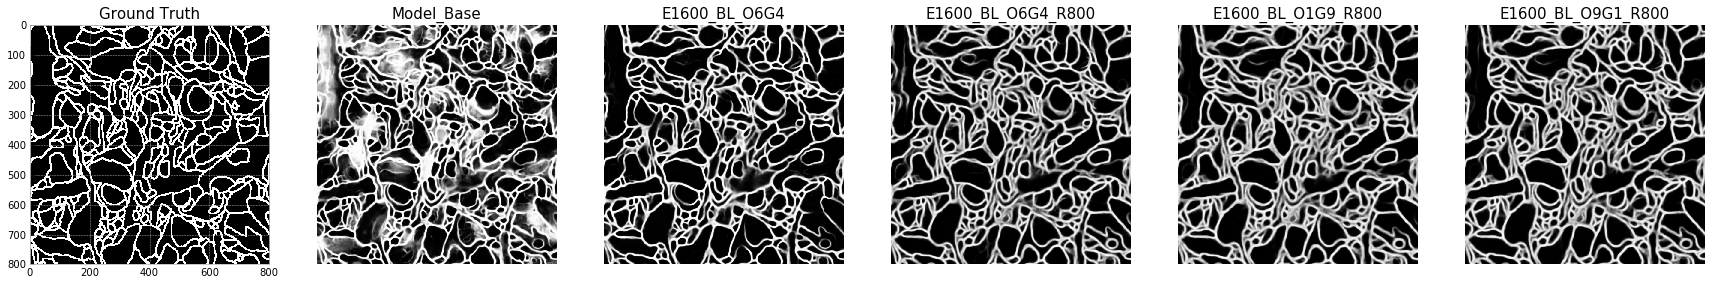


̲I̲m̲a̲g̲e̲s̲ ̲w̲i̲t̲h̲ ̲T̲h̲r̲e̲s̲h̲o̲l̲d̲ ̲v̲a̲l̲u̲e̲ ̲1̲0̲0̲,̲ ̲O̲v̲e̲r̲l̲a̲y̲ ̲(̲Y̲e̲l̲l̲o̲w̲:̲ ̲T̲r̲u̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲G̲r̲e̲e̲n̲:̲ ̲F̲a̲l̲s̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲,̲ ̲R̲e̲d̲:̲ ̲F̲a̲l̲s̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲B̲l̲a̲c̲k̲:̲ ̲T̲r̲u̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲)


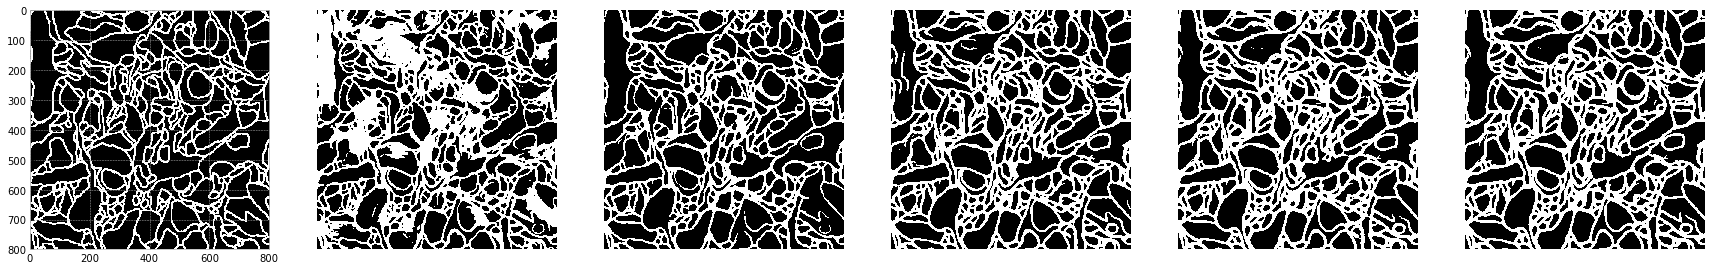

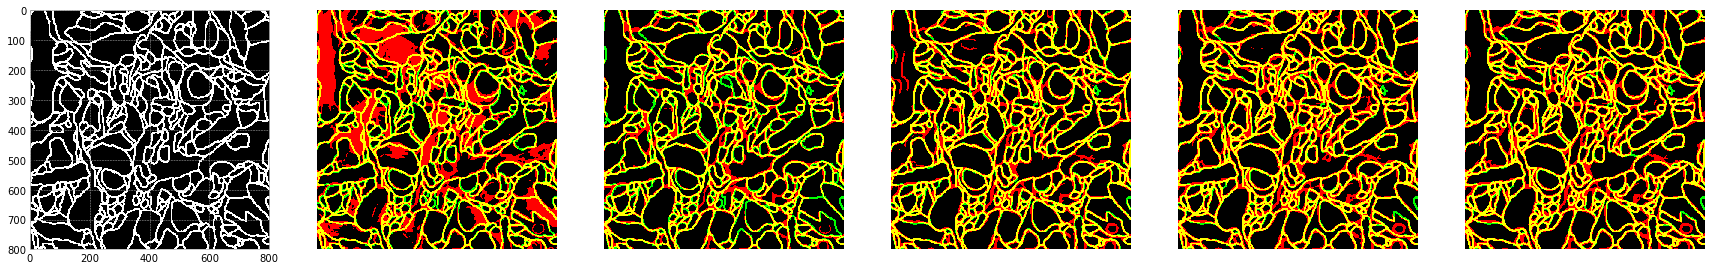


̲I̲m̲a̲g̲e̲s̲ ̲w̲i̲t̲h̲ ̲T̲h̲r̲e̲s̲h̲o̲l̲d̲ ̲v̲a̲l̲u̲e̲ ̲1̲2̲5̲,̲ ̲O̲v̲e̲r̲l̲a̲y̲ ̲(̲Y̲e̲l̲l̲o̲w̲:̲ ̲T̲r̲u̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲G̲r̲e̲e̲n̲:̲ ̲F̲a̲l̲s̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲,̲ ̲R̲e̲d̲:̲ ̲F̲a̲l̲s̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲B̲l̲a̲c̲k̲:̲ ̲T̲r̲u̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲)


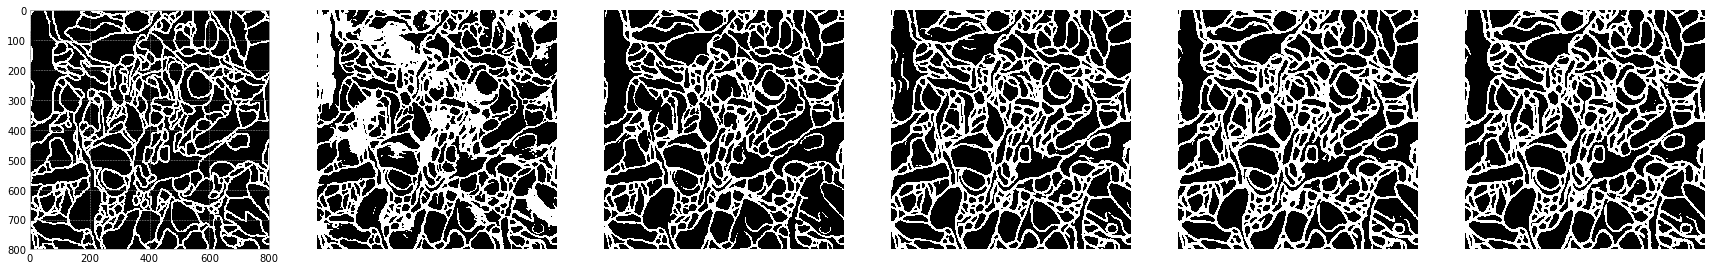

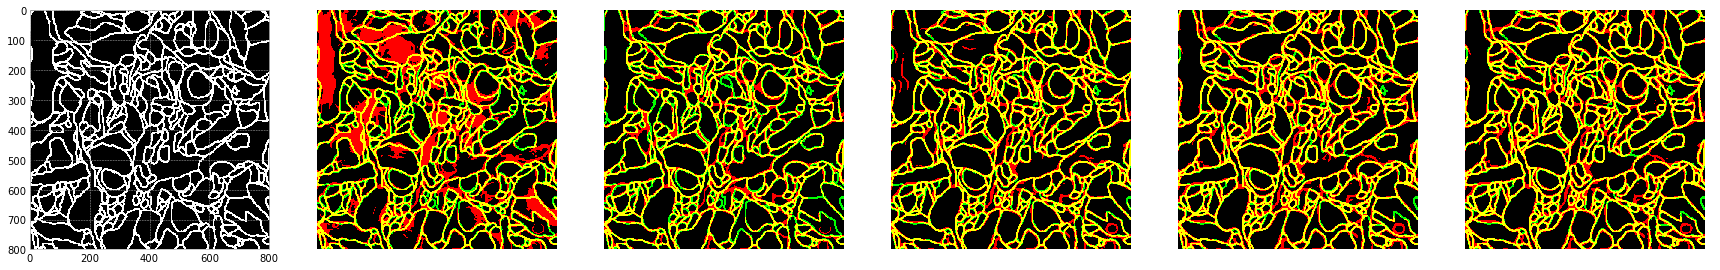


̲I̲m̲a̲g̲e̲s̲ ̲w̲i̲t̲h̲ ̲T̲h̲r̲e̲s̲h̲o̲l̲d̲ ̲v̲a̲l̲u̲e̲ ̲1̲3̲0̲,̲ ̲O̲v̲e̲r̲l̲a̲y̲ ̲(̲Y̲e̲l̲l̲o̲w̲:̲ ̲T̲r̲u̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲G̲r̲e̲e̲n̲:̲ ̲F̲a̲l̲s̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲,̲ ̲R̲e̲d̲:̲ ̲F̲a̲l̲s̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲B̲l̲a̲c̲k̲:̲ ̲T̲r̲u̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲)


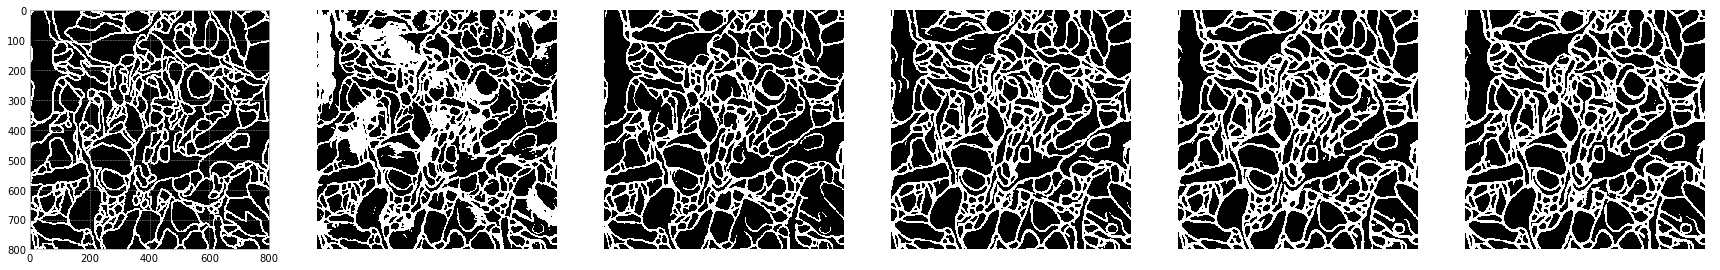

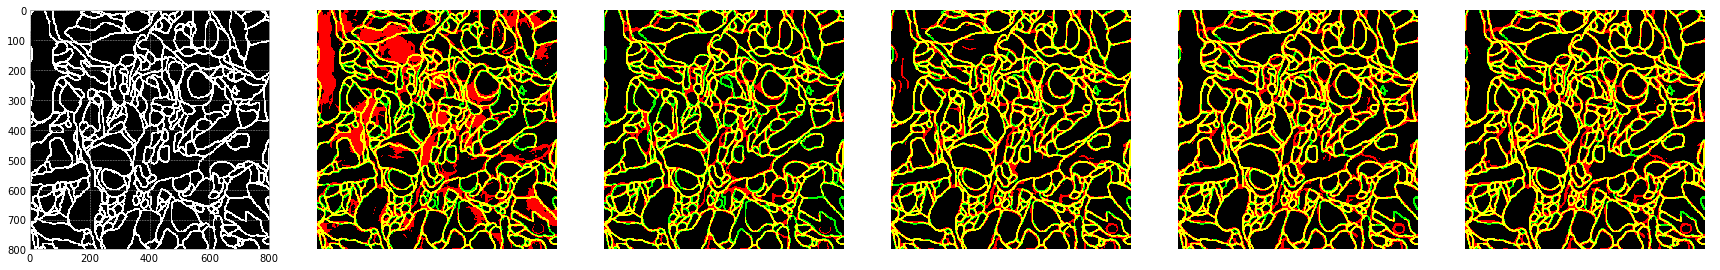


̲I̲m̲a̲g̲e̲s̲ ̲w̲i̲t̲h̲ ̲T̲h̲r̲e̲s̲h̲o̲l̲d̲ ̲v̲a̲l̲u̲e̲ ̲1̲5̲0̲,̲ ̲O̲v̲e̲r̲l̲a̲y̲ ̲(̲Y̲e̲l̲l̲o̲w̲:̲ ̲T̲r̲u̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲G̲r̲e̲e̲n̲:̲ ̲F̲a̲l̲s̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲,̲ ̲R̲e̲d̲:̲ ̲F̲a̲l̲s̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲B̲l̲a̲c̲k̲:̲ ̲T̲r̲u̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲)


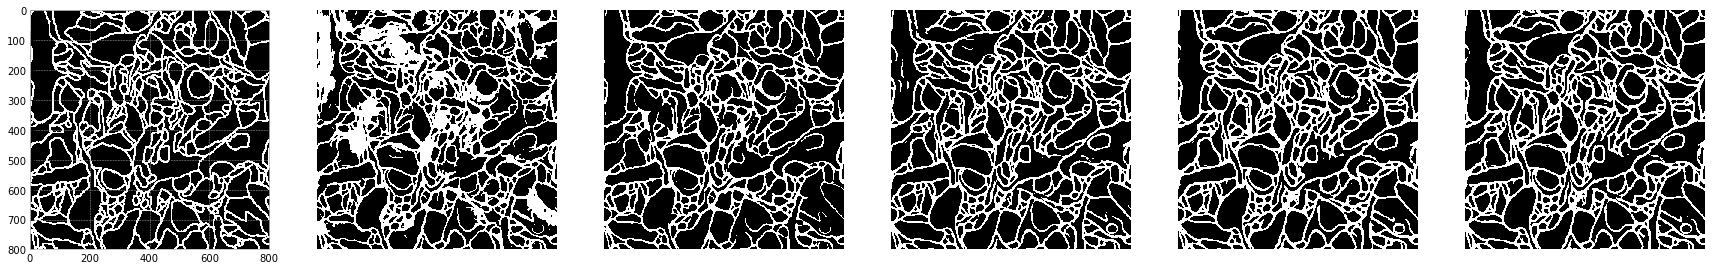

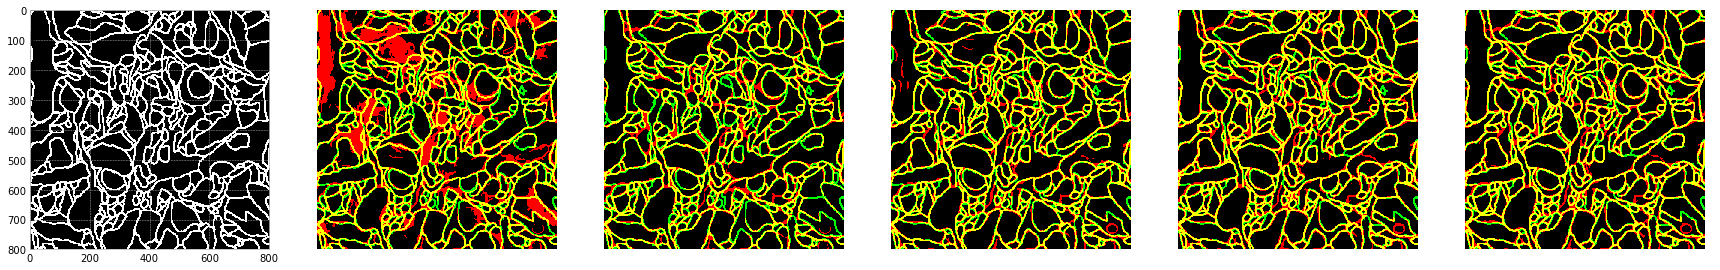


̲I̲m̲a̲g̲e̲s̲ ̲w̲i̲t̲h̲ ̲T̲h̲r̲e̲s̲h̲o̲l̲d̲ ̲v̲a̲l̲u̲e̲ ̲2̲0̲0̲,̲ ̲O̲v̲e̲r̲l̲a̲y̲ ̲(̲Y̲e̲l̲l̲o̲w̲:̲ ̲T̲r̲u̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲G̲r̲e̲e̲n̲:̲ ̲F̲a̲l̲s̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲,̲ ̲R̲e̲d̲:̲ ̲F̲a̲l̲s̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲B̲l̲a̲c̲k̲:̲ ̲T̲r̲u̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲)


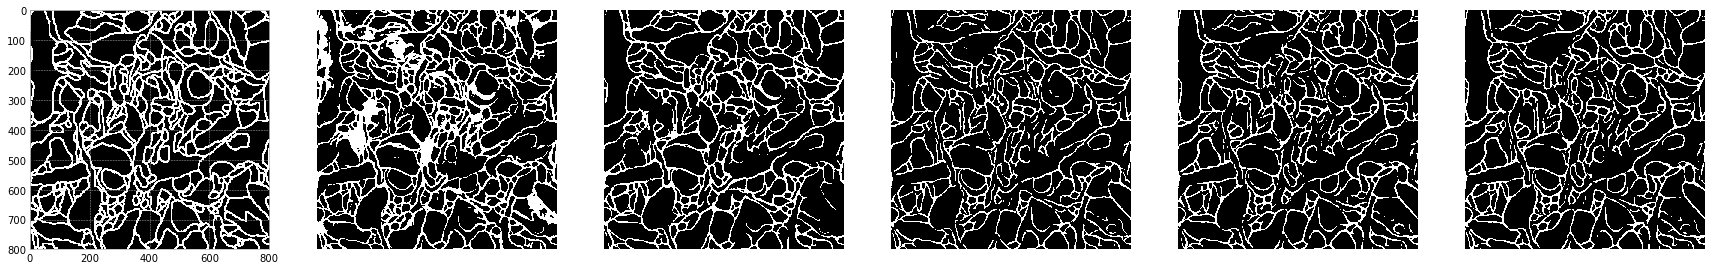

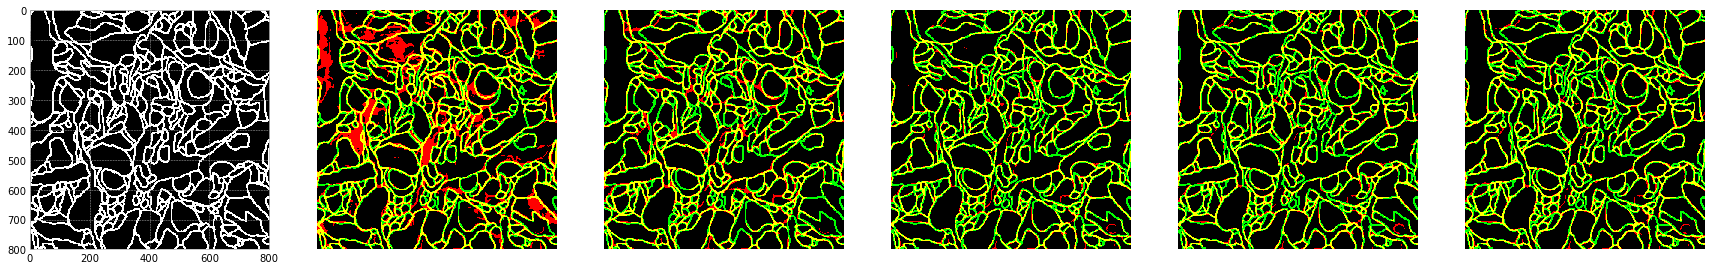

In [12]:
#Call the main methods to get the model performance
df_membranes = model_performance_main(organelle_membranes)




GROUND IMAGE (MITOS):slice0015_100_200_800_800.png

̲G̲r̲o̲u̲n̲d̲ ̲I̲m̲a̲g̲e̲ ̲v̲s̲ ̲P̲r̲e̲d̲i̲c̲t̲e̲d̲ ̲I̲m̲a̲g̲e̲s̲ ̲f̲r̲o̲m̲ ̲d̲i̲f̲f̲e̲r̲e̲n̲t̲ ̲m̲o̲d̲e̲l̲:


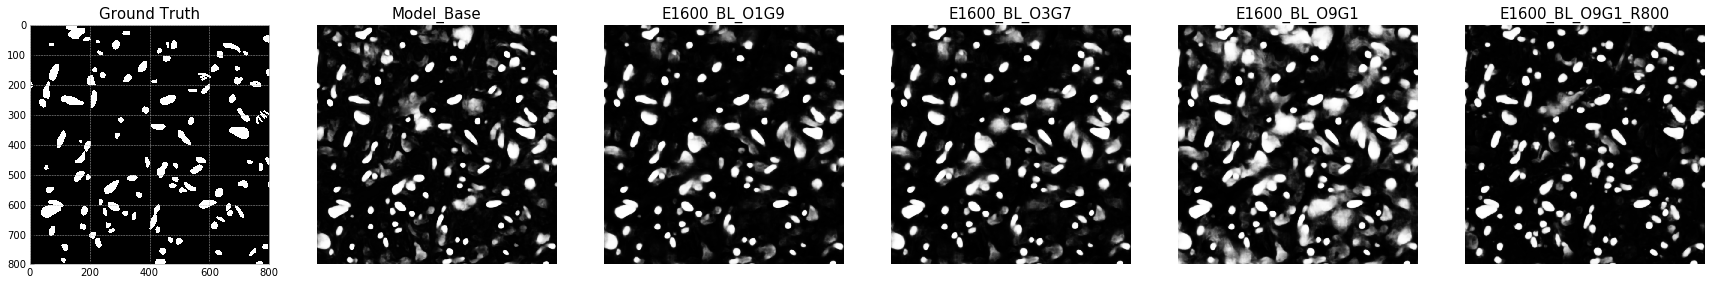


̲I̲m̲a̲g̲e̲s̲ ̲w̲i̲t̲h̲ ̲T̲h̲r̲e̲s̲h̲o̲l̲d̲ ̲v̲a̲l̲u̲e̲ ̲1̲0̲0̲,̲ ̲O̲v̲e̲r̲l̲a̲y̲ ̲(̲Y̲e̲l̲l̲o̲w̲:̲ ̲T̲r̲u̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲G̲r̲e̲e̲n̲:̲ ̲F̲a̲l̲s̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲,̲ ̲R̲e̲d̲:̲ ̲F̲a̲l̲s̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲B̲l̲a̲c̲k̲:̲ ̲T̲r̲u̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲)


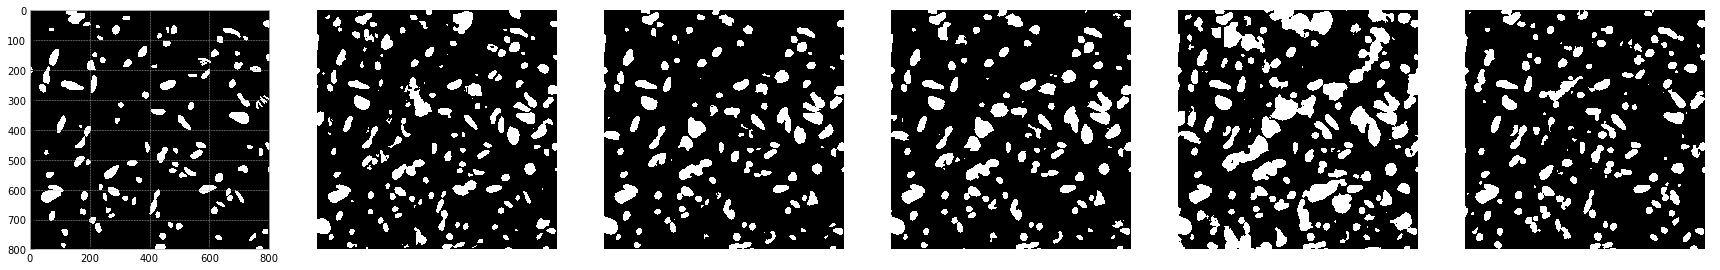

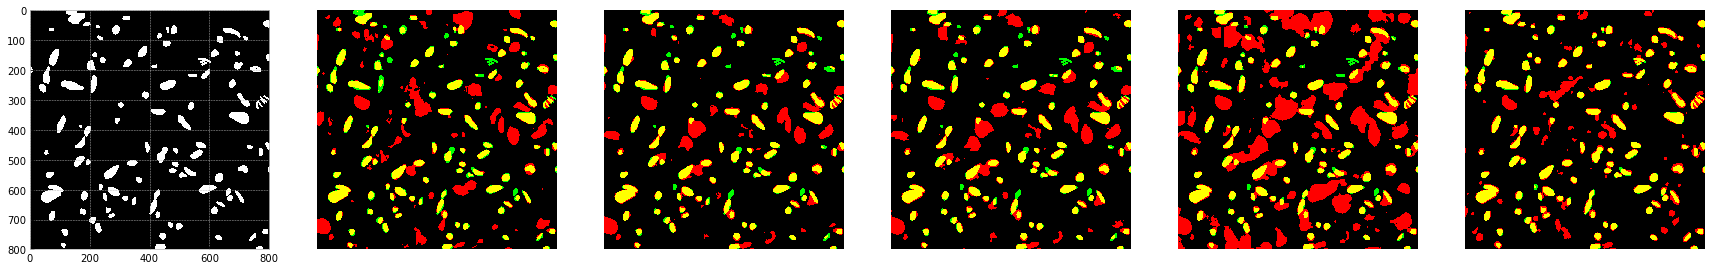


̲I̲m̲a̲g̲e̲s̲ ̲w̲i̲t̲h̲ ̲T̲h̲r̲e̲s̲h̲o̲l̲d̲ ̲v̲a̲l̲u̲e̲ ̲1̲2̲5̲,̲ ̲O̲v̲e̲r̲l̲a̲y̲ ̲(̲Y̲e̲l̲l̲o̲w̲:̲ ̲T̲r̲u̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲G̲r̲e̲e̲n̲:̲ ̲F̲a̲l̲s̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲,̲ ̲R̲e̲d̲:̲ ̲F̲a̲l̲s̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲B̲l̲a̲c̲k̲:̲ ̲T̲r̲u̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲)


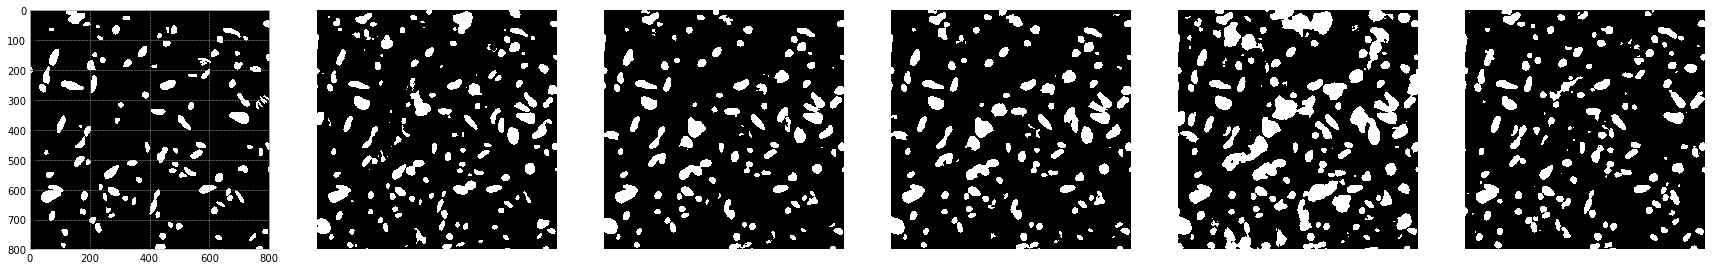

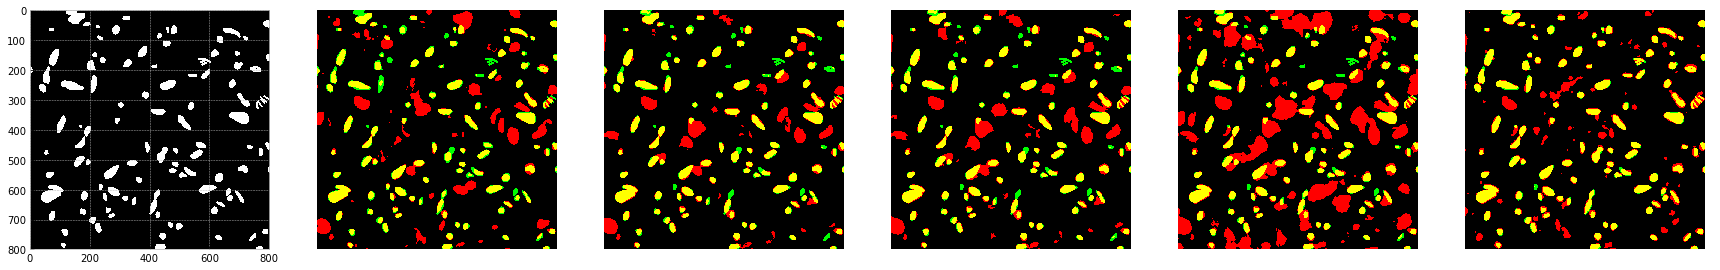


̲I̲m̲a̲g̲e̲s̲ ̲w̲i̲t̲h̲ ̲T̲h̲r̲e̲s̲h̲o̲l̲d̲ ̲v̲a̲l̲u̲e̲ ̲1̲3̲0̲,̲ ̲O̲v̲e̲r̲l̲a̲y̲ ̲(̲Y̲e̲l̲l̲o̲w̲:̲ ̲T̲r̲u̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲G̲r̲e̲e̲n̲:̲ ̲F̲a̲l̲s̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲,̲ ̲R̲e̲d̲:̲ ̲F̲a̲l̲s̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲B̲l̲a̲c̲k̲:̲ ̲T̲r̲u̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲)


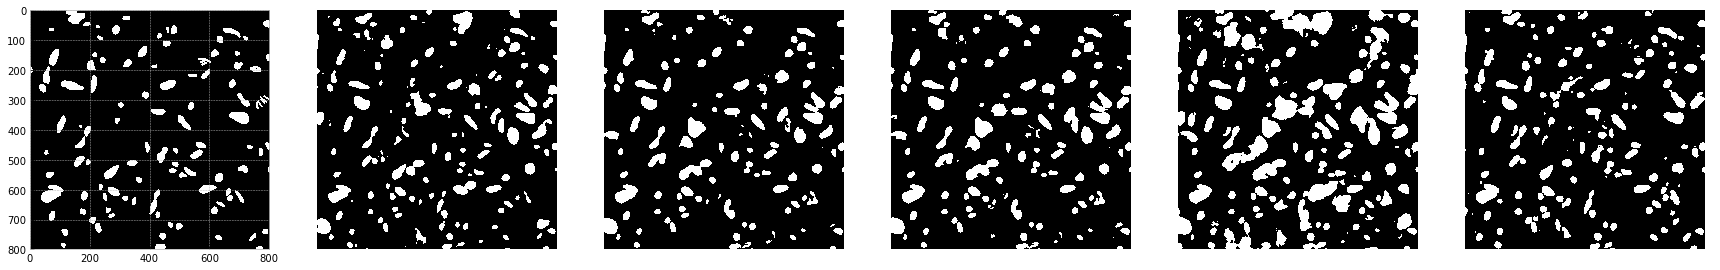

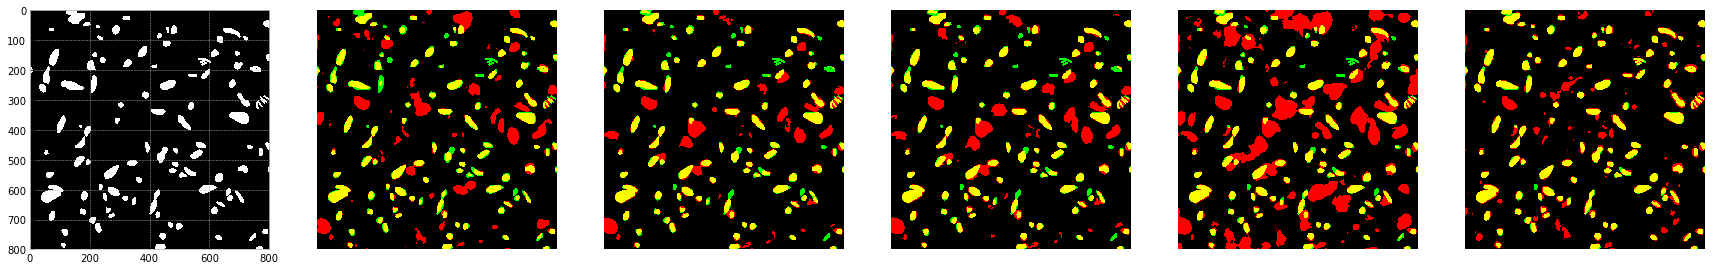


̲I̲m̲a̲g̲e̲s̲ ̲w̲i̲t̲h̲ ̲T̲h̲r̲e̲s̲h̲o̲l̲d̲ ̲v̲a̲l̲u̲e̲ ̲1̲5̲0̲,̲ ̲O̲v̲e̲r̲l̲a̲y̲ ̲(̲Y̲e̲l̲l̲o̲w̲:̲ ̲T̲r̲u̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲G̲r̲e̲e̲n̲:̲ ̲F̲a̲l̲s̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲,̲ ̲R̲e̲d̲:̲ ̲F̲a̲l̲s̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲B̲l̲a̲c̲k̲:̲ ̲T̲r̲u̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲)


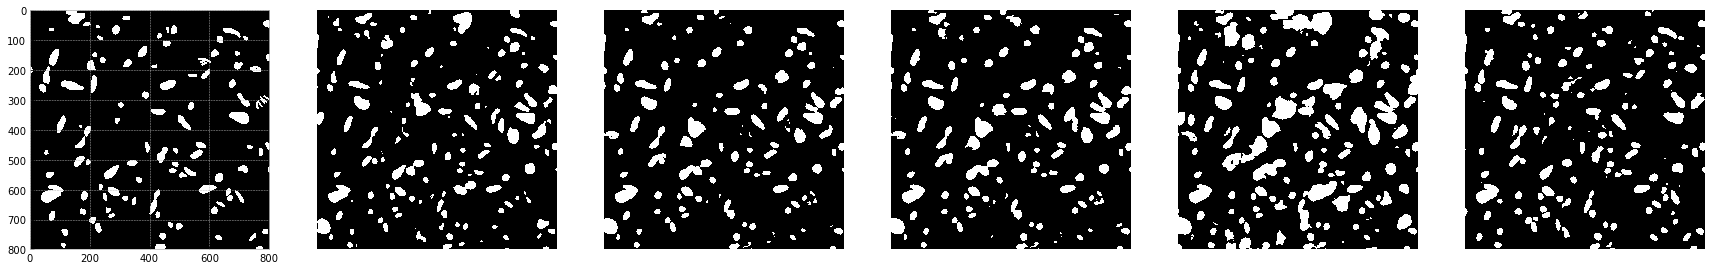

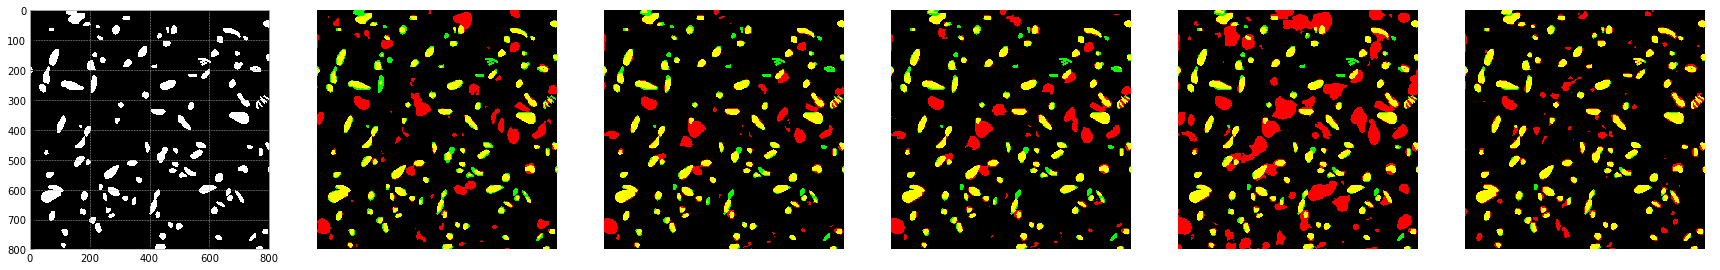


̲I̲m̲a̲g̲e̲s̲ ̲w̲i̲t̲h̲ ̲T̲h̲r̲e̲s̲h̲o̲l̲d̲ ̲v̲a̲l̲u̲e̲ ̲2̲0̲0̲,̲ ̲O̲v̲e̲r̲l̲a̲y̲ ̲(̲Y̲e̲l̲l̲o̲w̲:̲ ̲T̲r̲u̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲G̲r̲e̲e̲n̲:̲ ̲F̲a̲l̲s̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲,̲ ̲R̲e̲d̲:̲ ̲F̲a̲l̲s̲e̲ ̲P̲o̲s̲i̲t̲i̲v̲e̲,̲ ̲B̲l̲a̲c̲k̲:̲ ̲T̲r̲u̲e̲ ̲N̲e̲g̲a̲t̲i̲v̲e̲)


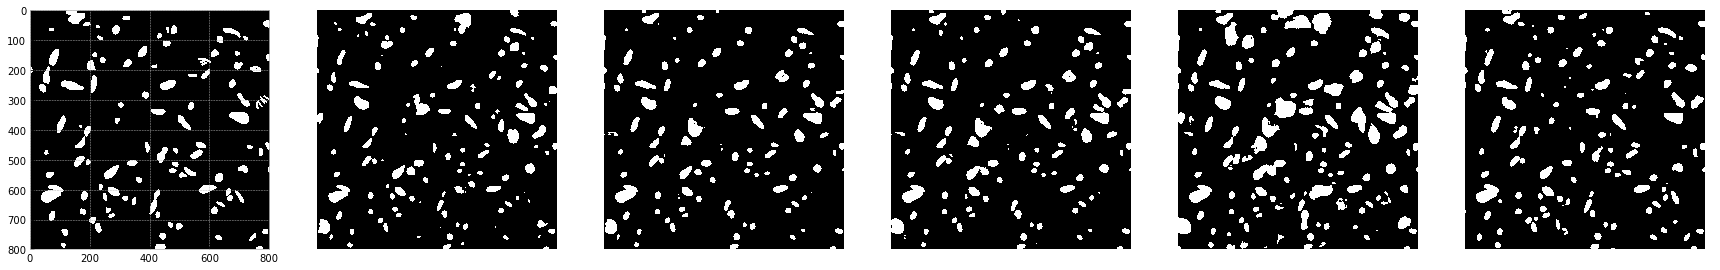

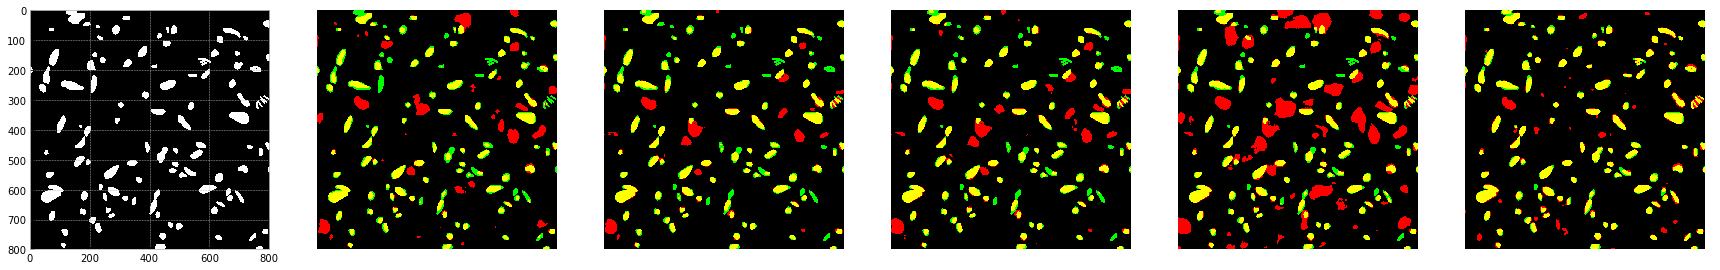

In [13]:
#Call the main methods to get the model performance for Mitochrondia
df_mitos = model_performance_main(organelle_mitos)


## Calculate F1-score and Accuracy improvement

In [14]:
def cal_f1_accuracy_gain(df_organelles):
    
    df_o=df_organelles.sort_values(by=['Model', 'Threshold'], ascending = (False, True))

    df_o1 = df_o.copy()
    df_base = df_o1[(df_o1['Model'] == base_model)] 

    for i, row in df_o1.iterrows():
        th = row['Threshold']
        base_f1 = df_base[df_base['Threshold']==th]['F1']
        base_acc = df_base[df_base['Threshold']==th]['Accuracy']

        mdl = row['Model']
        model_f1 = row['F1']
        model_acc = row['Accuracy']

        f1_improve = ((base_f1-model_f1)/base_f1)*100
        acc_improve = ((model_acc-base_acc)/base_acc)*100

        df_o1.at[i, 'F1-Improvement (%) on Base'] = round(float(f1_improve),2)
        df_o1.at[i, 'Accuracy-Improvement (%) on Base'] = round(float(acc_improve),2)
    return df_o1

## <u> MEMBRANES: </u>

## Display results from models with different thresholds

In [15]:
dfmem = cal_f1_accuracy_gain(df_membranes)

In [16]:
print("\nPerformance comparison in predicting Membranes:")
dfmem_arr = dfmem[cols]

dfmem_arr['Generated(%)'] = dfmem_arr['Generated(%)'].astype(int)
dfmem_arr['Original(%)'] = dfmem_arr['Original(%)'].astype(int)

# dfa = dfmem_arr.copy()
df_bg = dfmem_arr.copy()
cm = 'PuBu'
df_bg = df_bg.drop(drop_columns, axis=1) 
df_bg=df_bg.sort_values(by=['F1'], ascending = (False))
df_bg.set_index(hyperParam_col, inplace=True)
df_bg.style.background_gradient(cmap=cm)




Performance comparison in predicting Membranes:


## Sort results based on F-Beta value and desired threshold value from subjective analysis

In [17]:
# Highlight rows with above certain accuracy value and below certain F1 score

th = 125
print("\nCheck result set against desired threshold {} and sort by F-Beta for Membranes:".format(th))

dfam = dfmem_arr.copy()
dfam = dfam.drop(drop_columns, axis=1)  
dfam =dfam[(dfam.Threshold == th) ]
dfam=dfam.sort_values(by=['F_Beta'], ascending = (False))
dfam.set_index(hyperParam_col, inplace=True)$
dfam.style.background_gradient(cmap=cm)



Check result set against desired threshold 125 and sort by F-Beta for Membranes:


## Graphical plot for for few top models to show quantitative evaluation

<Figure size 432x288 with 0 Axes>

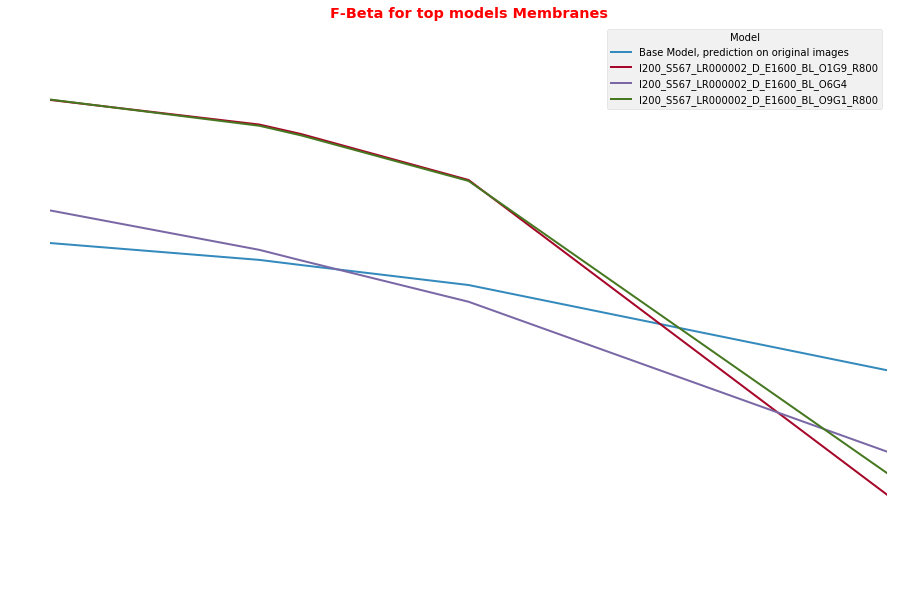

In [31]:

model = [base_model,
    'I200_S567_LR000002_D_E1600_BL_O1G9_R800',
    'I200_S567_LR000002_D_E1600_BL_O3G7_R800',
    'I200_S567_LR000002_D_E1600_BL_O9G1_R800',
    'I200_S567_LR000002_D_E1600_BL_O8G2_R800',
    'I200_S567_LR000002_D_E1600_BL_O7G3',
    'I200_S567_LR000002_D_E1600_BL_O6G4',

    ]
dfaa = df_membranes.copy()
for i, row in dfaa.iterrows():
    newName = row['Model'].split(":")[0]

    dfaa.at[i,'Model'] = newName
dff = dfaa
dff = dff[dff.Model.isin(model) ]
dff

plt.figure()
dfaaf = dff.pivot(index='Threshold', columns='Model', values='F_Beta')
dfaaf = dff.pivot(index='Threshold', columns='Model', values='F_Beta')

ax = dfaaf.plot(figsize=(15,10));

plt.xlabel('Pixel Threshold Value')
plt.ylabel('F-Beta Value')
ax.axis('off')
plt.ylim(ymin=0.5, ymax=0.90)
ax.set_title('F-Beta for top models Membranes', color='r', fontweight='bold')
ax.xaxis.label.set_color('red')
ax.xaxis.label.set_fontweight("bold")
ax.yaxis.label.set_color('red')
ax.yaxis.label.set_fontweight("bold")
ax.tick_params(axis='x', colors='yellow')
ax.tick_params(axis='y', colors='yellow')


plt.show()

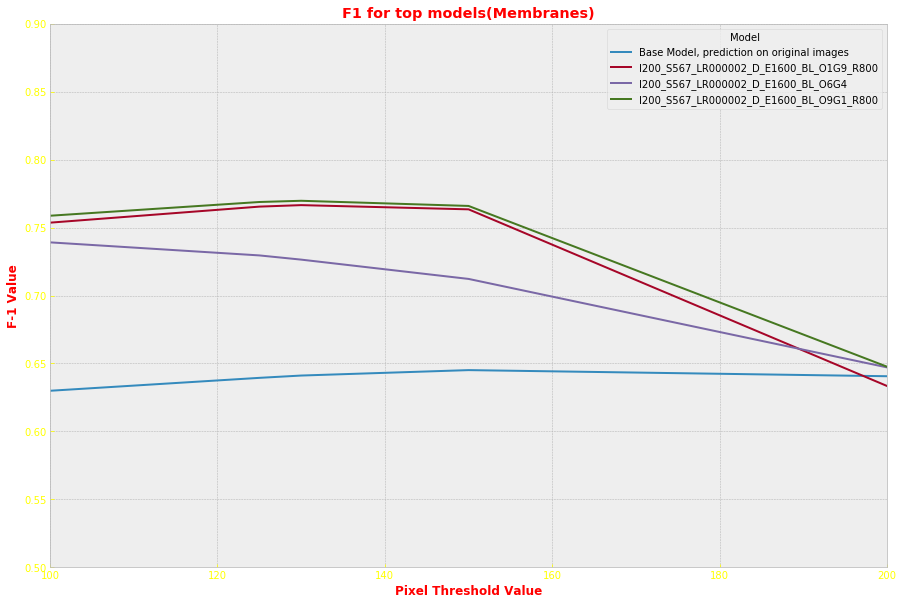

In [32]:
dfaaf = dff.pivot(index='Threshold', columns='Model', values='F1')
dfaaf = dff.pivot(index='Threshold', columns='Model', values='F1')

ax = dfaaf.plot(figsize=(15,10));

plt.xlabel('Pixel Threshold Value')
plt.ylabel('F-1 Value')
# ax.axis('off')
plt.ylim(ymin=0.5, ymax=0.90)
ax.set_title('F1 for top models(Membranes)', color='r', fontweight='bold')
ax.xaxis.label.set_color('red')
ax.xaxis.label.set_fontweight("bold")
ax.yaxis.label.set_color('red')
ax.yaxis.label.set_fontweight("bold")
ax.tick_params(axis='x', colors='yellow')
ax.tick_params(axis='y', colors='yellow')


plt.show()

# <u>MITOCHONDRIA:</u> 

## Display results from models with different thresholds

In [33]:
dfmitos = cal_f1_accuracy_gain(df_mitos)

In [43]:
print("\nPerformance comparison in predicting  Mitochondria:")
dfmitos_arr = dfmitos[cols]

df_bg = dfmitos_arr.copy()
df_bg = df_bg.drop(drop_columns, axis=1)  

df_bg['Generated(%)'] = df_bg['Generated(%)'].astype(int)
df_bg['Original(%)'] = df_bg['Original(%)'].astype(int)

df_bg.set_index(hyperParam_col, inplace=True)
df_bg.style.background_gradient(cmap='gray_r')



Performance comparison in predicting  Mitochondria:


## Sort results based on F-Beta value and desired threshold value from subjective analysis

In [42]:
th = 125
print("\nCheck result set against desired threshold {} and sort by F-Beta for Mitochondria:".format(th))

dfbm = dfmitos_arr.copy()
dfbm = dfbm.drop(drop_columns, axis=1)  
dfbm =dfbm[(dfbm.Threshold == th) ]
dfbm=dfbm.sort_values(by=['F1'], ascending = (False))

dfbm['Generated(%)'] = dfbm['Generated(%)'].astype(int)
dfbm['Original(%)'] = dfbm['Original(%)'].astype(int)

dfbm.set_index(hyperParam_col, inplace=True)
dfbm.style.background_gradient(cmap='gray_r')


Check result set against desired threshold 125 and sort by F-Beta for Mitochondria:


In [39]:
# dfmitos_arr

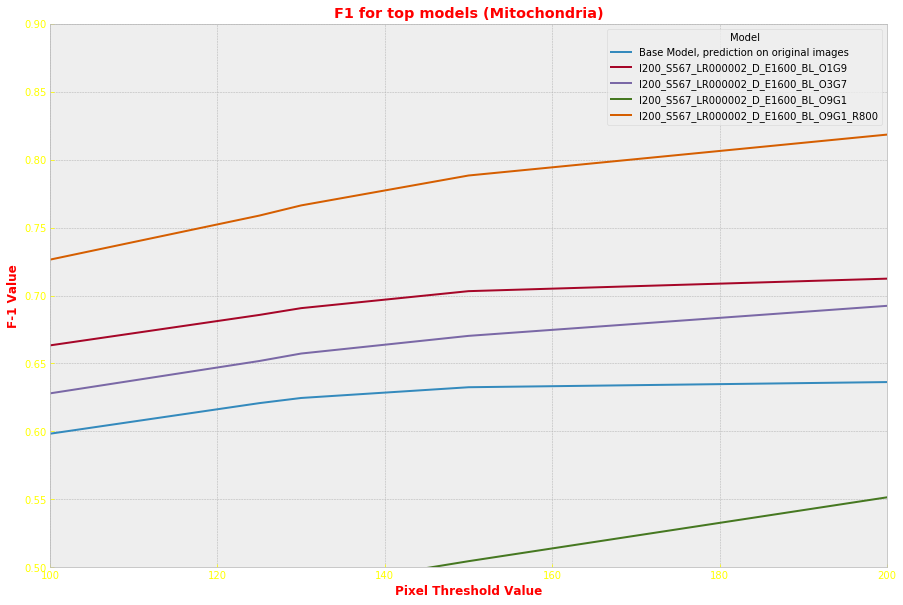

In [41]:
model_mito = [base_model,
#     'I200_S567_LR000002_D',
#     'I200_S567_LR000002_D_E1600',
    'I200_S567_LR000002_D_E1600_BL_O1G9',
    'I200_S567_LR000002_D_E1600_BL_O3G7',
    'I200_S567_LR000002_D_E1600_BL_O9G1',
#     'I200_S567_LR000002_D_E1600_BL_O1G9_R800',
    'I200_S567_LR000002_D_E1600_BL_O9G1_R800',
]


dfaa = dfmitos_arr.copy()
for i, row in dfaa.iterrows():
    newName = row['Model'].split(":")[0]

    dfaa.at[i,'Model'] = newName
dff = dfaa
dff = dff[dff.Model.isin(model_mito) ]


dfaaf = dff.pivot(index='Threshold', columns='Model', values='F1')
dfaaf = dff.pivot(index='Threshold', columns='Model', values='F1')

ax = dfaaf.plot(figsize=(15,10));

plt.xlabel('Pixel Threshold Value')
plt.ylabel('F-1 Value')
# ax.axis('off')
plt.ylim(ymin=0.5, ymax=0.90)
ax.set_title('F1 for top models (Mitochondria)', color='r', fontweight='bold')
ax.xaxis.label.set_color('red')
ax.xaxis.label.set_fontweight("bold")
ax.yaxis.label.set_color('red')
ax.yaxis.label.set_fontweight("bold")
ax.tick_params(axis='x', colors='yellow')
ax.tick_params(axis='y', colors='yellow')


plt.show()